In [2]:
# Imports
from os import makedirs
from os.path import join
import pickle
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.auto import tqdm
import sys
sys.path.append("..")

from sklearn.model_selection import ParameterGrid
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances

from fastdist import fastdist

from utils import get_model_checkpoint_filepaths

In [3]:
# Get last word embeddings from training
checkpoint_filepaths_dict = get_model_checkpoint_filepaths(
    output_dir="../output/word2vec_training/17-Oct-2020_01-00-56",
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights_filepath = checkpoint_filepaths_dict["intermediate_embedding_weight_filepaths"][-1]
last_embedding_weights = np.load(last_embedding_weights_filepath, mmap_mode="r").astype(np.float64)

In [6]:
# Load words and create word to int lookup dict
with open(checkpoint_filepaths_dict["train_words_filepath"], "r") as file:
    words = np.array(file.read().split("\n"))
word_to_int = {word: i for i, word in enumerate(words)}
vocab_size = 10000

In [24]:
# Precompute cosine distance (1 - similarity) matrix
word_embeddings_to_precompute = last_embedding_weights[:vocab_size]
word_embeddings_distances = 1 - fastdist.cosine_matrix_to_matrix(word_embeddings_to_precompute, word_embeddings_to_precompute)
np.fill_diagonal(word_embeddings_distances, 0)

In [25]:
word_embeddings_distances

array([[0.        , 0.37020598, 0.19383018, ..., 0.85871152, 0.78037951,
        0.81618062],
       [0.37020598, 0.        , 0.41384603, ..., 0.78202204, 0.76517178,
        0.70909416],
       [0.19383018, 0.41384603, 0.        , ..., 0.85636116, 0.84752284,
        0.92309059],
       ...,
       [0.85871152, 0.78202204, 0.85636116, ..., 0.        , 0.78838079,
        0.85520474],
       [0.78037951, 0.76517178, 0.84752284, ..., 0.78838079, 0.        ,
        0.80004739],
       [0.81618062, 0.70909416, 0.92309059, ..., 0.85520474, 0.80004739,
        0.        ]])

In [51]:
word_embeddings_distances

array([[0.        , 0.37020598, 0.19383018, ..., 0.85871152, 0.78037951,
        0.81618062],
       [0.37020598, 0.        , 0.41384603, ..., 0.78202204, 0.76517178,
        0.70909416],
       [0.19383018, 0.41384603, 0.        , ..., 0.85636116, 0.84752284,
        0.92309059],
       ...,
       [0.85871152, 0.78202204, 0.85636116, ..., 0.        , 0.78838079,
        0.85520474],
       [0.78037951, 0.76517178, 0.84752284, ..., 0.78838079, 0.        ,
        0.80004739],
       [0.81618062, 0.70909416, 0.92309059, ..., 0.85520474, 0.80004739,
        0.        ]])

In [26]:
def cluster_hyperparameters_search(
    clusterers: list,
    clusterer_names: list,
    clusterer_hyperparam_grids: list,
    vocab_size: int,
    word_embeddings: np.ndarray,
    output_filepath_suffix: str,
    output_dir: str = None,
    model_name: str = None,
    dataset_name: str = None,
    pairwise_dists: np.ndarray = None,
    fit_on_pairwise_dists: bool = False
):
    """
    TODO: Docs
    """
    # Ensure output directory exists
    makedirs(output_dir, exist_ok=True)
    
    # Default to all words if -1
    if vocab_size == -1:
        vocab_size = len(word_embeddings)
    
    # Only fit/evaluate on max `vocab_size` words.
    if pairwise_dists is None and not fit_on_pairwise_dists:
        word_embeddings_fit = word_embeddings[:vocab_size]
        word_embeddings_pairwise_dists = pairwise_distances(word_embeddings_fit)
    elif pairwise_dists is not None and fit_on_pairwise_dists:
        word_embeddings_fit = pairwise_dists
        word_embeddings_pairwise_dists = pairwise_dists
    
    # Fit and predict cluster labels
    cluster_labels = {}
    for clusterer, clusterer_name, hyperparam_grid in zip(clusterers, clusterer_names, clusterer_hyperparam_grids):
        print(f"-- Fitting and predicting cluster labels using {clusterer_name} --")
        cluster_labels[clusterer_name] = {
            "labels": [],
            "metric_values": [],
            "best_labels_idx": -1
        }
        clusterer_metric_values = []
        for hyperparams in tqdm(hyperparam_grid):
            cls = clusterer(**hyperparams)
            cluster_labels_pred = cls.fit_predict(word_embeddings_fit)
            cluster_labels[clusterer_name]["labels"].append(cluster_labels_pred)
            cluster_metric_value = silhouette_score(word_embeddings_pairwise_dists, cluster_labels_pred, metric="precomputed")
            clusterer_metric_values.append(cluster_metric_value)
        
        cluster_labels[clusterer_name]["metric_values"] = clusterer_metric_values
        cluster_labels[clusterer_name]["best_labels_idx"] = np.argmax(clusterer_metric_values)
        
    
    # Save to output dir
    if output_dir is not None and model_name is not None and dataset_name is not None:
        output_path = join(output_dir, f"{model_name}-{dataset_name}-{output_filepath_suffix}.pkl")
        with open(output_path, "wb") as file:
            pickle.dump(cluster_labels, file)
    
    return cluster_labels

In [27]:
should_pred_cluster_labels = True
ks = [2, 3, 4, 5, 10, 50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
if should_pred_cluster_labels:
    pred_cluster_labels = cluster_hyperparameters_search(
        clusterers=[
            AgglomerativeClustering
        ],
        clusterer_names=[
            "Agglomerative clustering"
        ],
        clusterer_hyperparam_grids=[
            ParameterGrid({
                "n_clusters": ks,
                "affinity": ["precomputed"],
                "linkage": ["average"],
            })
        ],
        vocab_size=vocab_size,
        word_embeddings=last_embedding_weights,
        output_filepath_suffix="agglomerative_labels",
        output_dir="../output/word2vec_cluster_analysis",
        model_name="word2vec",
        dataset_name="enwiki",
        pairwise_dists=word_embeddings_distances,
        fit_on_pairwise_dists=True
    )
else:
    with open("../output/word2vec_cluster_analysis/word2vec-enwiki-agglomerative_labels.pkl", "rb") as file:
        pred_cluster_labels = pickle.load(file)

-- Fitting and predicting cluster labels using Agglomerative clustering --


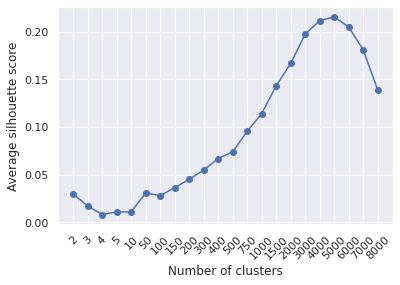

In [28]:
silhouette_scores = pred_cluster_labels["Agglomerative clustering"]["metric_values"]
xs = range(len(ks))

plt.plot(xs, silhouette_scores)
plt.scatter(xs, silhouette_scores)
plt.xticks(xs, ks, rotation=45)
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.show()

In [53]:
# TODO: Zoom inn på 4000-6000.
should_pred_cluster_labels_zoomed = True
ks_zoomed = np.linspace(4000, 6000, num=100, dtype=int)
if should_pred_cluster_labels_zoomed:
    pred_cluster_labels_zoomed = cluster_hyperparameters_search(
        clusterers=[
            AgglomerativeClustering
        ],
        clusterer_names=[
            "Agglomerative clustering"
        ],
        clusterer_hyperparam_grids=[
            ParameterGrid({
                "n_clusters": ks_zoomed,
                "affinity": ["precomputed"],
                "linkage": ["average"],
            })
        ],
        vocab_size=vocab_size,
        word_embeddings=last_embedding_weights,
        output_filepath_suffix="agglomerative_labels_zoomed",
        output_dir="../output/word2vec_cluster_analysis",
        model_name="word2vec",
        dataset_name="enwiki",
        pairwise_dists=word_embeddings_distances,
        fit_on_pairwise_dists=True
    )
else:
    with open("../output/word2vec_cluster_analysis/word2vec-enwiki-agglomerative_labels_zoomed.pkl", "rb") as file:
        pred_cluster_labels = pickle.load(file)

-- Fitting and predicting cluster labels using Agglomerative clustering --


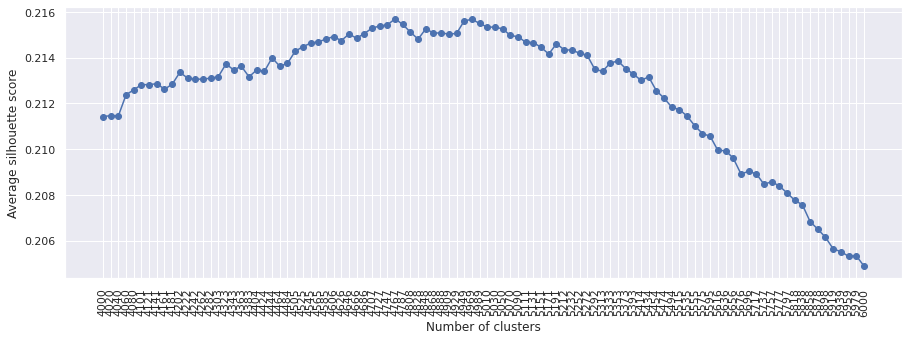

In [54]:
silhouette_scores_zoomed = pred_cluster_labels_zoomed["Agglomerative clustering"]["metric_values"]
xs_zoomed = range(len(ks_zoomed))

plt.figure(figsize=(15, 5))
plt.plot(xs_zoomed, silhouette_scores_zoomed)
plt.scatter(xs_zoomed, silhouette_scores_zoomed)
plt.xticks(xs_zoomed, ks_zoomed, rotation=90)
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.show()

In [57]:
best_cluster_numbers_sorted = ks_zoomed[np.argsort(silhouette_scores_zoomed)[::-1]]

In [70]:
best_agglomerative_clustering_model = AgglomerativeClustering(
    n_clusters=None,#best_cluster_numbers_sorted[0],
    affinity="precomputed",
    linkage="average",
    distance_threshold=0
)
best_agglomerative_clustering_model.fit(word_embeddings_distances)

AgglomerativeClustering(affinity='precomputed', distance_threshold=0,
                        linkage='average', n_clusters=None)

In [79]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    return linkage_matrix

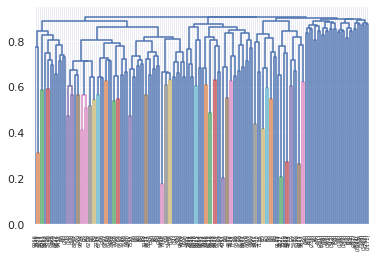

In [80]:
linkage_matrix = plot_dendrogram(best_agglomerative_clustering_model, truncate_mode='level', p=7)

In [88]:
from scipy.cluster.hierarchy import fcluster
best_labels_fclust = fcluster(linkage_matrix, criterion="maxclust", t=best_cluster_numbers_sorted[1])

In [94]:
all_test_labels = []
all_scores = []
for i in tqdm(range(2, 6000)):
    test_labels = fcluster(linkage_matrix, criterion="maxclust", t=i)
    test_labels_score = silhouette_score(last_embedding_weights[:vocab_size], test_labels)
    all_test_labels.append(test_labels)
    all_scores.append(test_labels_score)

KeyboardInterrupt: 

In [89]:
silhouette_score(word_embeddings_distances, best_labels_fclust, metric="precomputed")

0.2156773034620652

2 clusters: max=9483, min=517, ratio=18.342359767891683


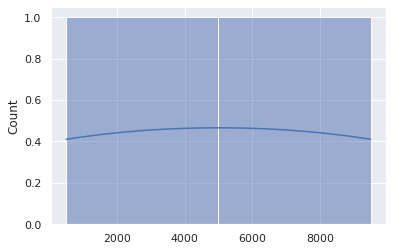

---
3 clusters: max=9411, min=72, ratio=130.70833333333334


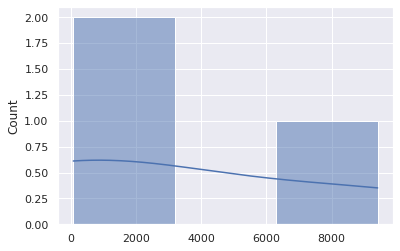

---
4 clusters: max=9367, min=44, ratio=212.88636363636363


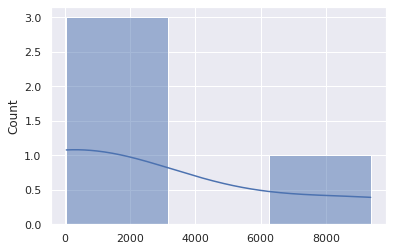

---
5 clusters: max=7623, min=44, ratio=173.25


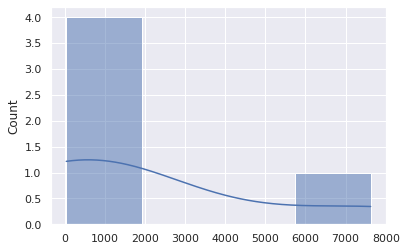

---
10 clusters: max=4864, min=17, ratio=286.11764705882354


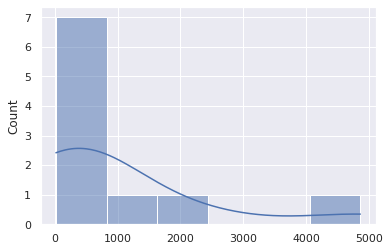

---
50 clusters: max=1220, min=3, ratio=406.6666666666667


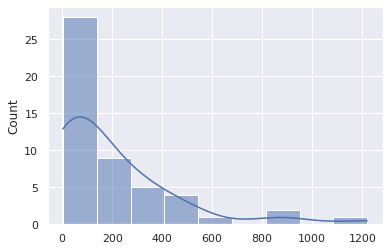

---
100 clusters: max=1095, min=2, ratio=547.5


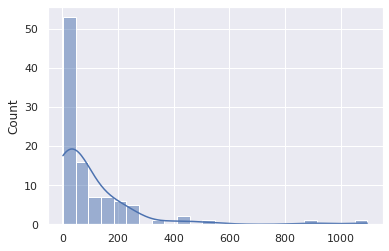

---
150 clusters: max=899, min=2, ratio=449.5


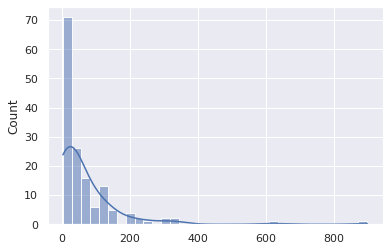

---
200 clusters: max=563, min=1, ratio=563.0


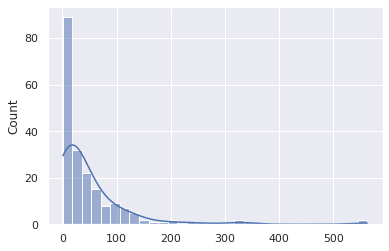

---
300 clusters: max=555, min=1, ratio=555.0


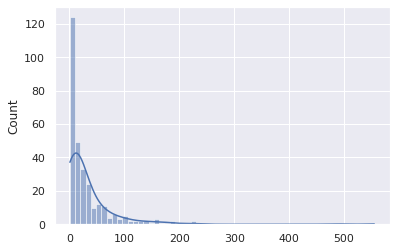

---
400 clusters: max=529, min=1, ratio=529.0


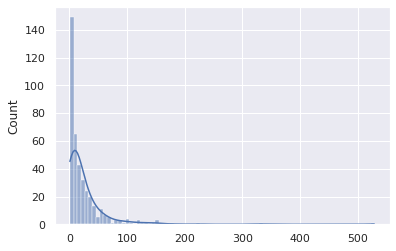

---
500 clusters: max=516, min=1, ratio=516.0


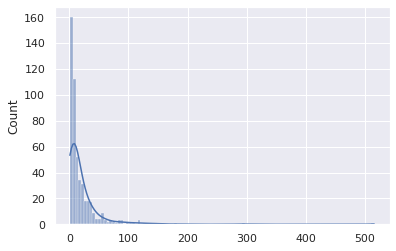

---
750 clusters: max=419, min=1, ratio=419.0


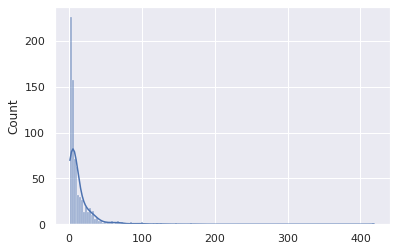

---
1000 clusters: max=331, min=1, ratio=331.0


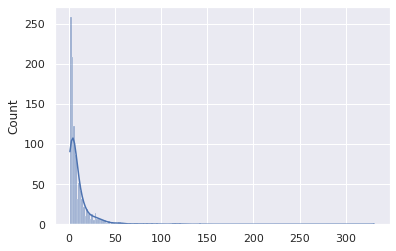

---
1500 clusters: max=218, min=1, ratio=218.0


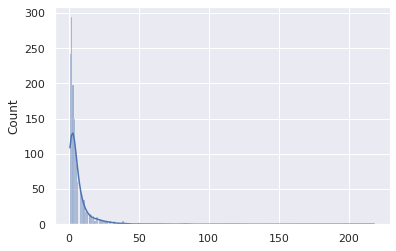

---
2000 clusters: max=191, min=1, ratio=191.0


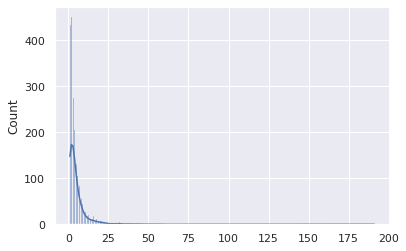

---
3000 clusters: max=101, min=1, ratio=101.0


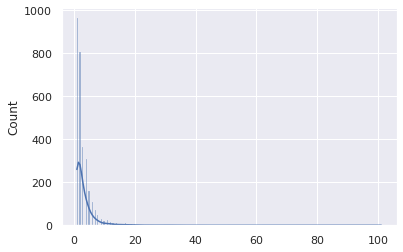

---
4000 clusters: max=101, min=1, ratio=101.0


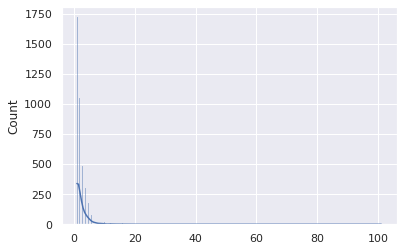

---
5000 clusters: max=101, min=1, ratio=101.0


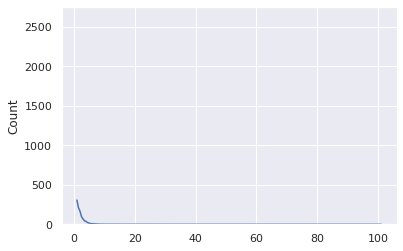

---
6000 clusters: max=101, min=1, ratio=101.0


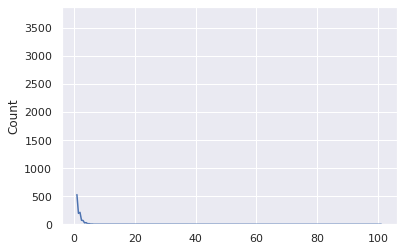

---
7000 clusters: max=73, min=1, ratio=73.0


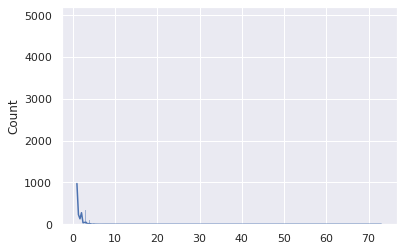

---
8000 clusters: max=41, min=1, ratio=41.0


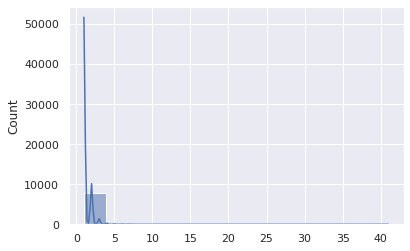

---


In [43]:
# Compute cluster size ratios (maximum cluster size / minimum cluster size)
for labels in pred_cluster_labels["Agglomerative clustering"]["labels"]:
    labels_unique, labels_counts = np.unique(labels, return_counts=True)
    num_clusters = len(labels_unique)
    max_cluster_size = max(labels_counts)
    min_cluster_size = min(labels_counts)
    cluster_size_ratio = max_cluster_size / min_cluster_size
    print(f"{num_clusters} clusters: max={max_cluster_size}, min={min_cluster_size}, ratio={cluster_size_ratio}")
    
    # Plot distribution of cluster sizes
    sns.histplot(labels_counts, kde=True)
    plt.show()
    
    print("---")

In [10]:
# Se hvilke ord som forekommer i forskjellige clustre (e.g. største, minste, osv)

In [44]:
def words_in_clusters(cluster_labels: np.ndarray, words: np.ndarray) -> tuple:
    """
    TODO: Docs
    """
    labels_unique, labels_counts = np.unique(cluster_labels, return_counts=True)
    cluster_words = []
    for cluster_label in labels_unique:
        words_in_cluster = words[cluster_labels == cluster_label]
        cluster_words.append(words_in_cluster)
    cluster_words = np.array(cluster_words)
    return cluster_words, labels_counts

In [45]:
cluster_words, cluster_sizes = words_in_clusters(
    cluster_labels=pred_cluster_labels["Agglomerative clustering"]["labels"][-4],
    words=words[:vocab_size]
)

In [46]:
biggest_cluster_idx = np.argmax(cluster_sizes)
smallest_cluster_idx = np.argmin(cluster_sizes[cluster_sizes >= 5])

In [47]:
cluster_words[biggest_cluster_idx]

array(['thousand', 'one', 'hundred', 'two', 'nine', 'eight', 'three',
       'four', 'five', 'six', 'seven', 'ten', 'twelve', 'eleven',
       'fifteen', 'twenty', 'eighteen', 'fourteen', 'sixteen', 'thirteen',
       'seventeen', 'nineteen', 'thirty', 'fifty', 'twenty-five',
       'eighty', 'ninety', 'sixty', 'forty', 'twenty-four', 'seventy',
       'twenty-one', 'twenty-two', 'twenty-three', 'twenty-eight',
       'twenty-seven', 'twenty-six', 'ninety-nine', 'twenty-nine',
       'ninety-eight', 'ninety-five', 'thirty-one', 'ninety-six',
       'ninety-seven', 'sixty-five', 'forty-five', 'ninety-two',
       'ninety-four', 'ninety-three', 'seventy-five', 'ninety-one',
       'eighty-nine', 'eighty-eight', 'eighty-five', 'sixty-four',
       'eighty-six', 'eighty-seven', 'thirty-five', 'eighty-four',
       'forty-four', 'seventy-two', 'eighty-three', 'eighty-two',
       'seventy-six', 'eighty-one', 'sixty-eight', 'seventy-eight',
       'seventy-nine', 'forty-eight', 'thirty-two',

In [52]:
cluster_words[cluster_sizes >= 10][smallest_cluster_idx]

array(['regiment', 'corps', 'infantry', 'brigade', 'battalion',
       'artillery', 'cavalry', 'battalions', 'regiments', 'marines',
       'troop', 'brigades', 'platoon'], dtype='<U58')

In [ ]:
# TODO: K-mediods (og agglomerative)?